# **Purpose**

**Our purpose is to predict the total sales of every product in stores for the next month, given the datasets**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We are installing all the required modules, including the SHAP module, which is used to analyze the feature importance of each feature in the model

In [39]:
!pip install shap
import shap


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Uncomment this code if running the code on Kaggle. Be sure to comment the next cell if that is the case

"""items = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
sales_train = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
sample = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")
"""

In [40]:
#If running on the system, where csv files are in the same directory as this file

items = pd.read_csv("items.csv")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv")
sample = pd.read_csv("sample_submission.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")


**Features present**

* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date - date** in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

# **EDA**

In [41]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [42]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [43]:
df_train = sales_train
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [44]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [45]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [46]:
df_train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


We observe that item_price and item_id are weakly negatively correlated

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>],
       [<AxesSubplot:title={'center':'item_cnt_day'}>, <AxesSubplot:>]],
      dtype=object)

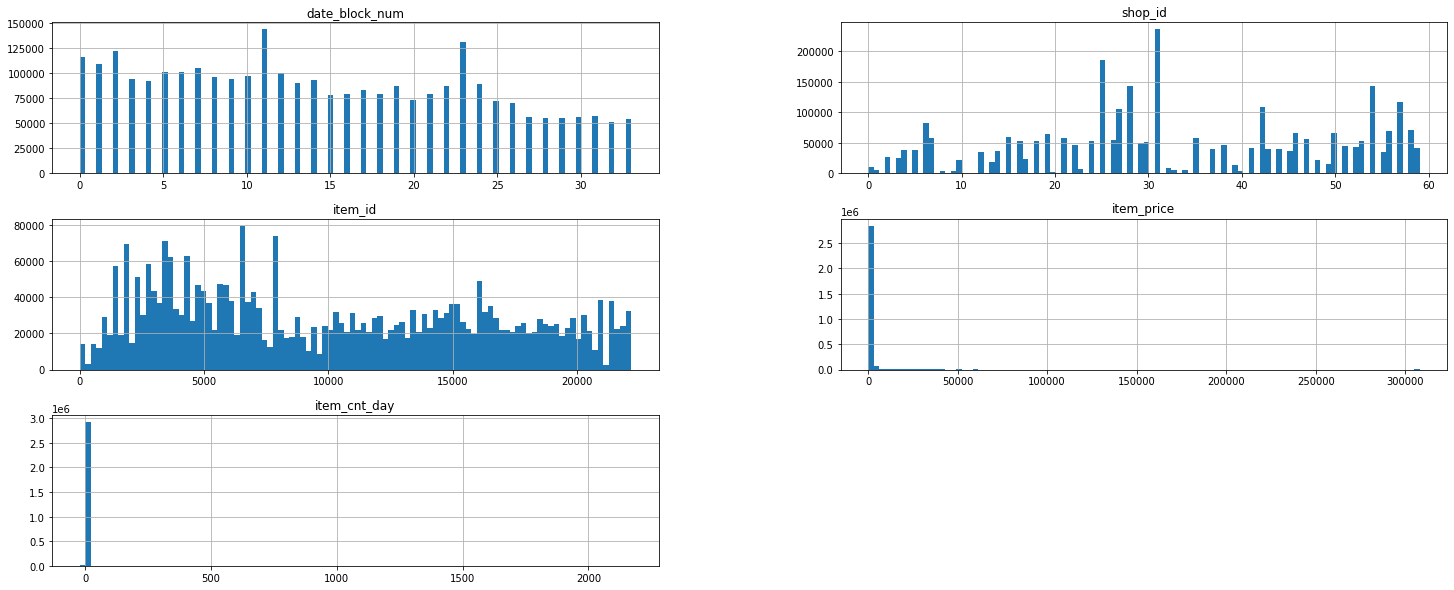

In [47]:
df_train.hist(bins=100, figsize = (25,10))

In [48]:
df_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

# **DATA PREPROCESSING**

We have to check how many NULL values are present in our Dataframe

In [49]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [50]:
df_train.shape

(2935849, 6)

Since there are no NULL values, the next step is to drop the duplicates if any exist

In [51]:
df_train.drop_duplicates(inplace=True)

In [52]:
df_train.shape

(2935843, 6)

We have to then check if the item_price and item_cnt_day follows normal distribution.

If it does, we can use the 3 sigma thumb rule and remove the outliers whose values exceed 3 times the standard deviation

<function matplotlib.pyplot.show(close=None, block=None)>

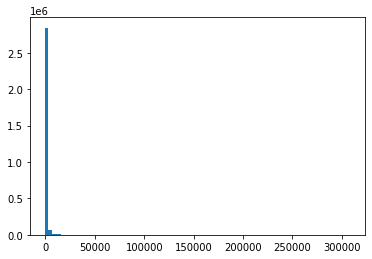

In [53]:
plt.hist(df_train["item_price"],bins=100)
plt.show

(array([2.935534e+06, 2.540000e+02, 2.500000e+01, 1.000000e+01,
        5.000000e+00, 5.000000e+00, 5.000000e+00, 3.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([ -22.  ,   65.64,  153.28,  240.92,  328.56,  416.2 ,  503.84,
         591.48,  679.12,  766.76,  854.4 ,  942.04, 1029.68, 1117.32,
        1204.96, 1292.6 , 1380.24, 1467.88, 1555.52, 1643.16, 1730.8 ,
        1818.44, 1906.08, 1993.72, 2081.36, 2169.  ]),
 <BarContainer object of 25 artists>)

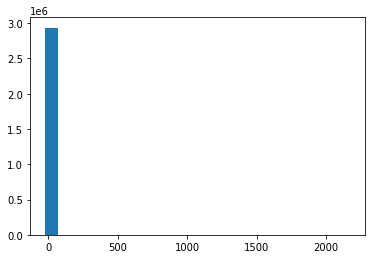

In [54]:
plt.hist(df_train["item_cnt_day"],bins=25)

As observed visually above, none of these variables follow normal distribution. Let us verify using a qqplot

In [55]:
from statsmodels.graphics.gofplots import qqplot

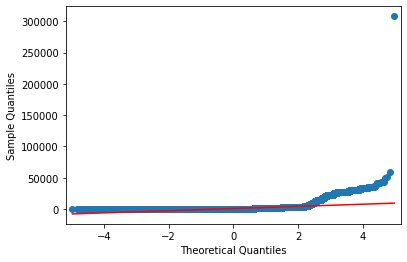

In [56]:
qqplot(df_train["item_price"],line='s');

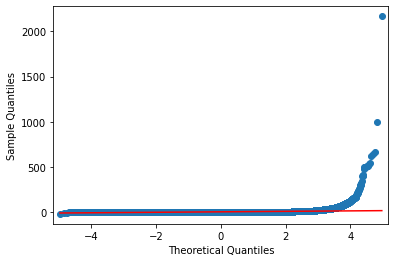

In [57]:
qqplot(df_train["item_cnt_day"],line='s');

Since we see that there is a lot of outliers, we make the decision to drop the records where the values exceed the 3 times the standard deviation

This as we see will result in a better model, because including these outliers will surely increase the error of the model

We can also drop records with negative item_price and item_cnt_day, since this might be a result of faulty recording of data. There is no use of such records

In [58]:
df_train.drop(df_train[df_train.item_price > 3 * df_train.item_price.std()].index, inplace = True)
df_train.drop(df_train[df_train.item_cnt_day > 3 * df_train.item_cnt_day.std()].index, inplace = True)
df_train.drop(df_train[df_train.item_price < 0].index, inplace = True)
df_train.drop(df_train[df_train.item_cnt_day < 0].index, inplace = True)

# **FEATURE ENGINEERING**

Now, we have to decide on what features are necessary to build our model.

Firstly, the features shop_id, item_id and item_categories_id are definitely required as a features

Also, we will be using the sales in the past months for each shop and item to predict the target variable

Here, our target variable in consideration is the item_cnt_day for the 33rd month (when data_block_num = 33)

In [59]:
df=df_train.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').fillna(0.0)
df.head()

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  22.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

After pivoting, we have to reshape the table by managing the index, so we use the reset_index method on the pivot table



In [60]:
df_train = df.reset_index()
df_train.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [62]:
item_categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [63]:
item_cat_df = items.merge(item_categories[['item_category_id','item_category_name']], how="inner", on="item_category_id")[['item_id','item_category_name']]


In [64]:
df_train = df_train.merge(item_cat_df, how="inner", on="item_id")
df_train.dropna(axis=1,inplace=True)

In [65]:
df_train.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_name
0,0,30,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Кино - DVD
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD


In [66]:
df_train.corr()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
shop_id,1.000000,0.010566,-0.024208,-0.034819,0.021192,0.026979,0.026828,0.023805,0.023975,0.023956,...,0.026182,0.021933,0.024481,0.008681,0.008968,0.007752,0.013270,0.014820,0.006158,-0.002181
item_id,0.010566,1.000000,-0.046311,-0.059834,-0.049592,-0.035700,-0.028829,-0.025310,-0.021712,-0.039811,...,-0.033438,-0.023859,-0.024330,-0.021111,-0.022240,-0.024955,-0.018252,-0.030556,-0.033241,-0.010304
0,-0.024208,-0.046311,1.000000,0.557091,0.354618,0.284448,0.232361,0.192700,0.188866,0.175344,...,0.055736,0.046432,0.045725,0.030717,0.024735,0.020518,0.020060,0.019435,0.011520,0.016647
1,-0.034819,-0.059834,0.557091,1.000000,0.458145,0.319411,0.231583,0.194847,0.183756,0.190240,...,0.048338,0.049320,0.044833,0.028208,0.024986,0.023680,0.018309,0.022543,0.015371,0.015834
2,0.021192,-0.049592,0.354618,0.458145,1.000000,0.553113,0.337725,0.252402,0.252458,0.240397,...,0.076192,0.073335,0.067569,0.041707,0.035340,0.031872,0.029406,0.030337,0.021264,0.024349
3,0.026979,-0.035700,0.284448,0.319411,0.553113,1.000000,0.512576,0.312571,0.283531,0.249440,...,0.076851,0.076217,0.072125,0.060549,0.047118,0.040520,0.040139,0.041476,0.028739,0.034290
4,0.026828,-0.028829,0.232361,0.231583,0.337725,0.512576,1.000000,0.568931,0.482668,0.411625,...,0.188522,0.180678,0.155643,0.165443,0.170339,0.144330,0.162359,0.165769,0.142640,0.152837
5,0.023805,-0.025310,0.192700,0.194847,0.252402,0.312571,0.568931,1.000000,0.700461,0.540539,...,0.260727,0.234571,0.185497,0.200354,0.214822,0.183246,0.216423,0.238830,0.199929,0.219749
6,0.023975,-0.021712,0.188866,0.183756,0.252458,0.283531,0.482668,0.700461,1.000000,0.662963,...,0.298790,0.278486,0.207859,0.231687,0.253466,0.225795,0.264100,0.265246,0.227750,0.247133
7,0.023956,-0.039811,0.175344,0.190240,0.240397,0.249440,0.411625,0.540539,0.662963,1.000000,...,0.289749,0.264979,0.215125,0.238007,0.242990,0.209544,0.250388,0.244413,0.214274,0.223401


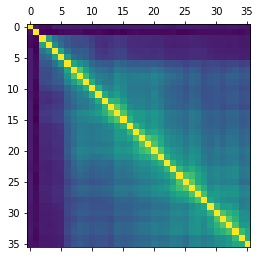

In [67]:
plt.matshow(df_train.corr())
plt.show()

# **Model Building and Training**

In [68]:
from sklearn import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *

First, we have to use the item category name also as a feature, there is a chance that it could affect the target variable prediction

In [69]:
EN = preprocessing.LabelEncoder()
df_train['item_category_name'] = EN.fit_transform(df_train['item_category_name'])
df_train.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_name
0,0,30,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [70]:
#df_train['item_category_name'] = EN.fit_transform(df_train['item_category_name'])
df_train = df_train[['shop_id', 'item_id', 'item_category_name'] + list(range(34))]
df_train.head()

,shop_id,item_id,item_category_name,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,0.0,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df_train.dtypes

shop_id                 int64
item_id                 int64
item_category_name      int32
0                     float64
1                     float64
2                     float64
3                     float64
4                     float64
5                     float64
6                     float64
7                     float64
8                     float64
9                     float64
10                    float64
11                    float64
12                    float64
13                    float64
14                    float64
15                    float64
16                    float64
17                    float64
18                    float64
19                    float64
20                    float64
21                    float64
22                    float64
23                    float64
24                    float64
25                    float64
26                    float64
27                    float64
28                    float64
29                    float64
30        

In [72]:
X = df_train.iloc[:,  (df_train.columns != 33)].values
y = df_train.iloc[:,  (df_train.columns == 33)].values

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0
                                                    , train_size=0.80
                                                    , test_size=0.20)

**Model 1: XGBoost model, using parameters**

We are using this algorithm on the basis of research papers and that XGBoost is in general one of the better regression models used.

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable

In [74]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import *

     ---------------------------------------- 89.1/89.1 MB 1.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
param = {'max_depth': 20, 
         'eta':0.34, 
         'seed':1,
         'eval_metric':'rmse'}


xgbtrain = xgb.DMatrix(X_train,y_train)

xgbmodel1 = xgb.train(param, xgbtrain)
preds = xgbmodel1.predict(xgb.DMatrix(X_valid))
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

0.6188668252486774


The RMSE obtained is 0.6188668252486774.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

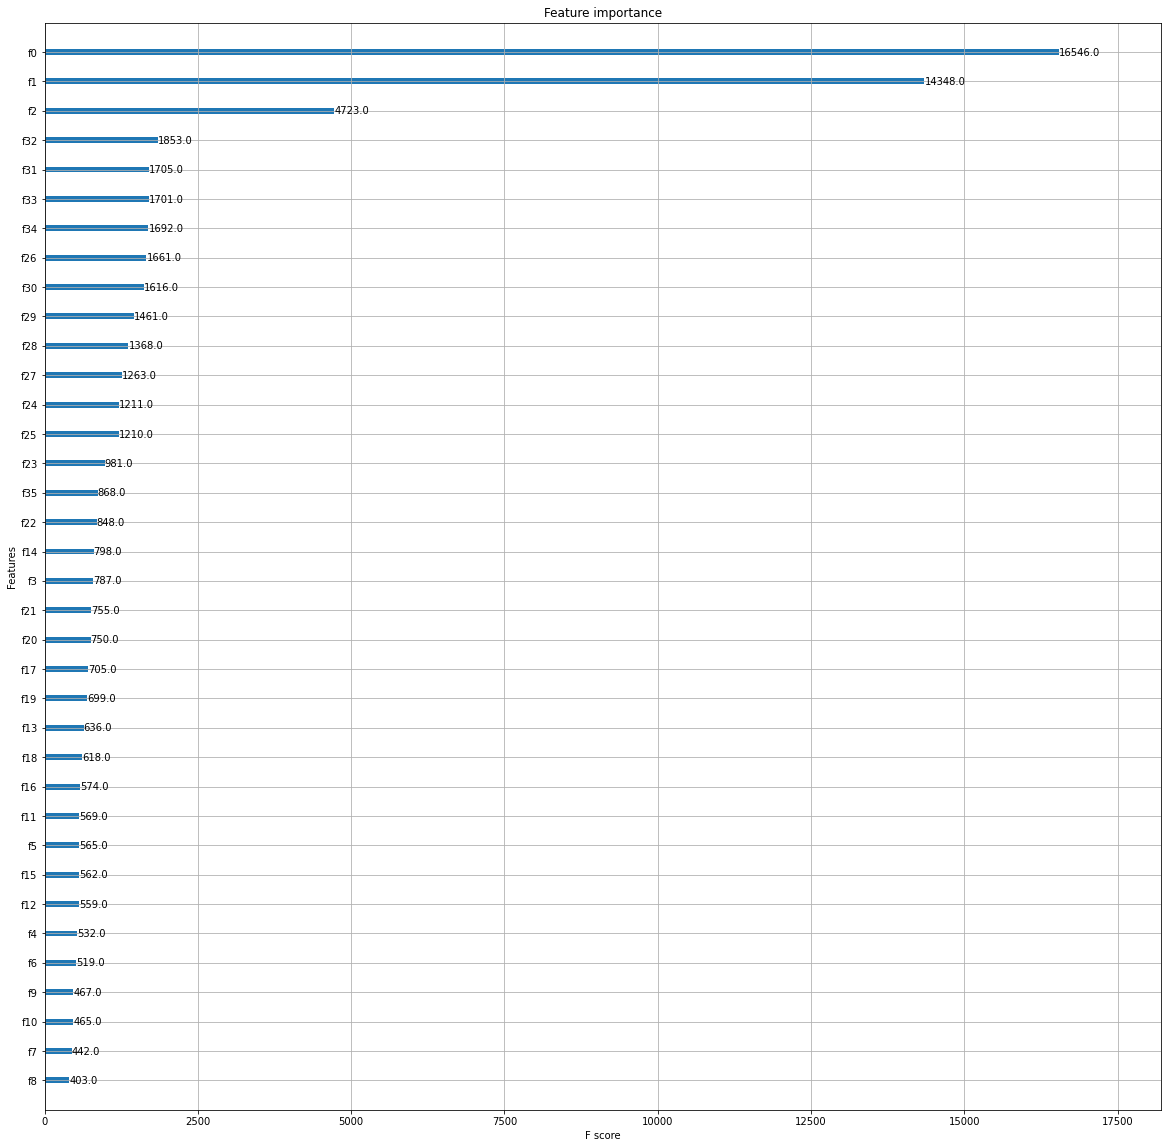

In [76]:
fig, ax = plt.subplots(figsize = (20, 20))
xgb.plot_importance(xgbmodel1, ax = ax)

Seeing this feature importance, we see that item_id and shop_id contribute the most, followed by item_category_label.

Also, we see that the higher number features contribute more to the model than the lower numbered features (excluding f0, f1, f2)

In [77]:
xgbmodel2 = xgb.XGBRegressor()
xgbmodel2.fit(X_train, y_train)

preds = xgbmodel2.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

0.5949148538179692


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

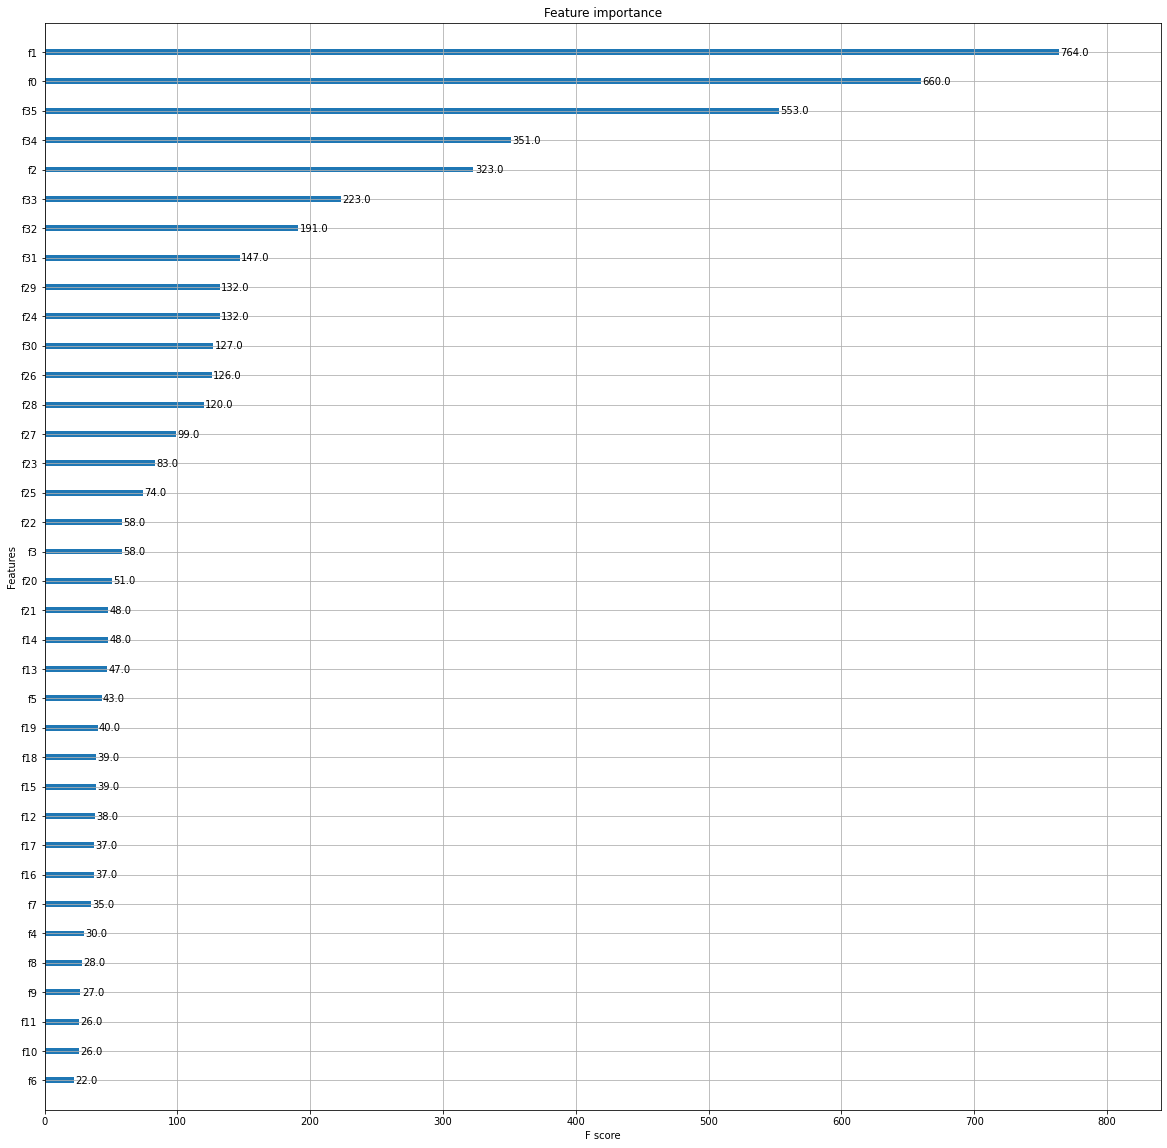

In [78]:
fig, ax = plt.subplots(figsize = (20, 20))
xgb.plot_importance(xgbmodel2, ax = ax)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


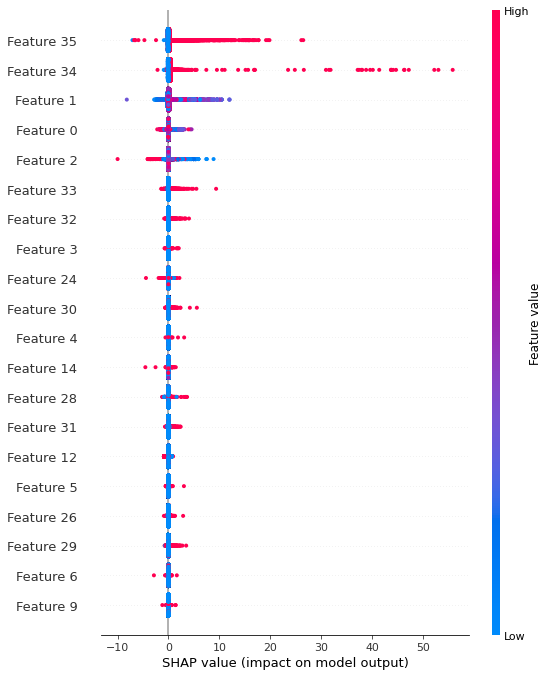

In [79]:
explainer = shap.TreeExplainer(xgbmodel2)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

Here we observe that the top 4 most contributing features are the same, even though they are of different values

In Impurity based XGBoost importance, it shows f1,f0, f35, f34 in decreasing order. This is because impurity-base importance explains the feature usage for generalizing on the train set;

In SHAP plot, it shows f35, f34, f1, f0 in decreasing order. SHAP explains how much would changing a feature value affect the prediction

**Model 2: LightGBM with parameters**



In [80]:
!pip install lightgbm
import lightgbm as lgb


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 1.0/1.0 MB 1.4 MB/s eta 0:00:00


In [81]:
lgbtrain = lgb.Dataset(X_train, y_train)

param = {'num_leaves': 250, 'objective': 'regression','max_depth': 30}

num_round = 10
bst = lgb.train(param, lgbtrain, num_round)

preds = bst.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

Converting column-vector to 1d array


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 334482, number of used features: 36
[LightGBM] [Info] Start training from score 0.142830
0.739961925247503


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

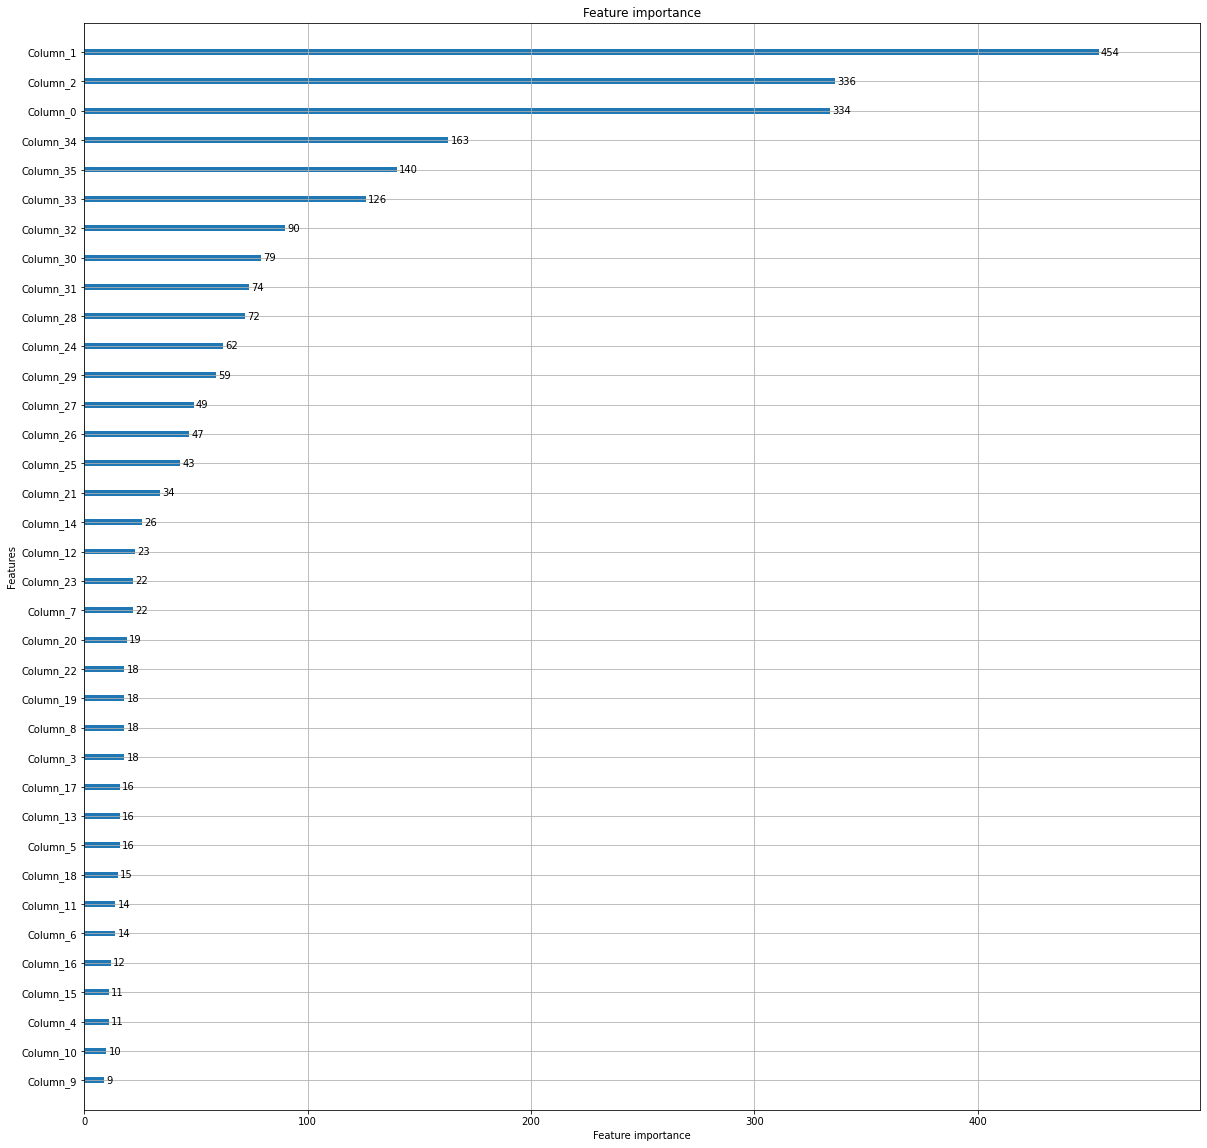

In [82]:
fig, ax = plt.subplots(figsize = (20, 20))
lgb.plot_importance(bst, ax = ax)

In [83]:
lgbmodel = lgb.LGBMRegressor()
lgbmodel.fit(X_train, y_train)

preds = lgbmodel.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.6510968210461612


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

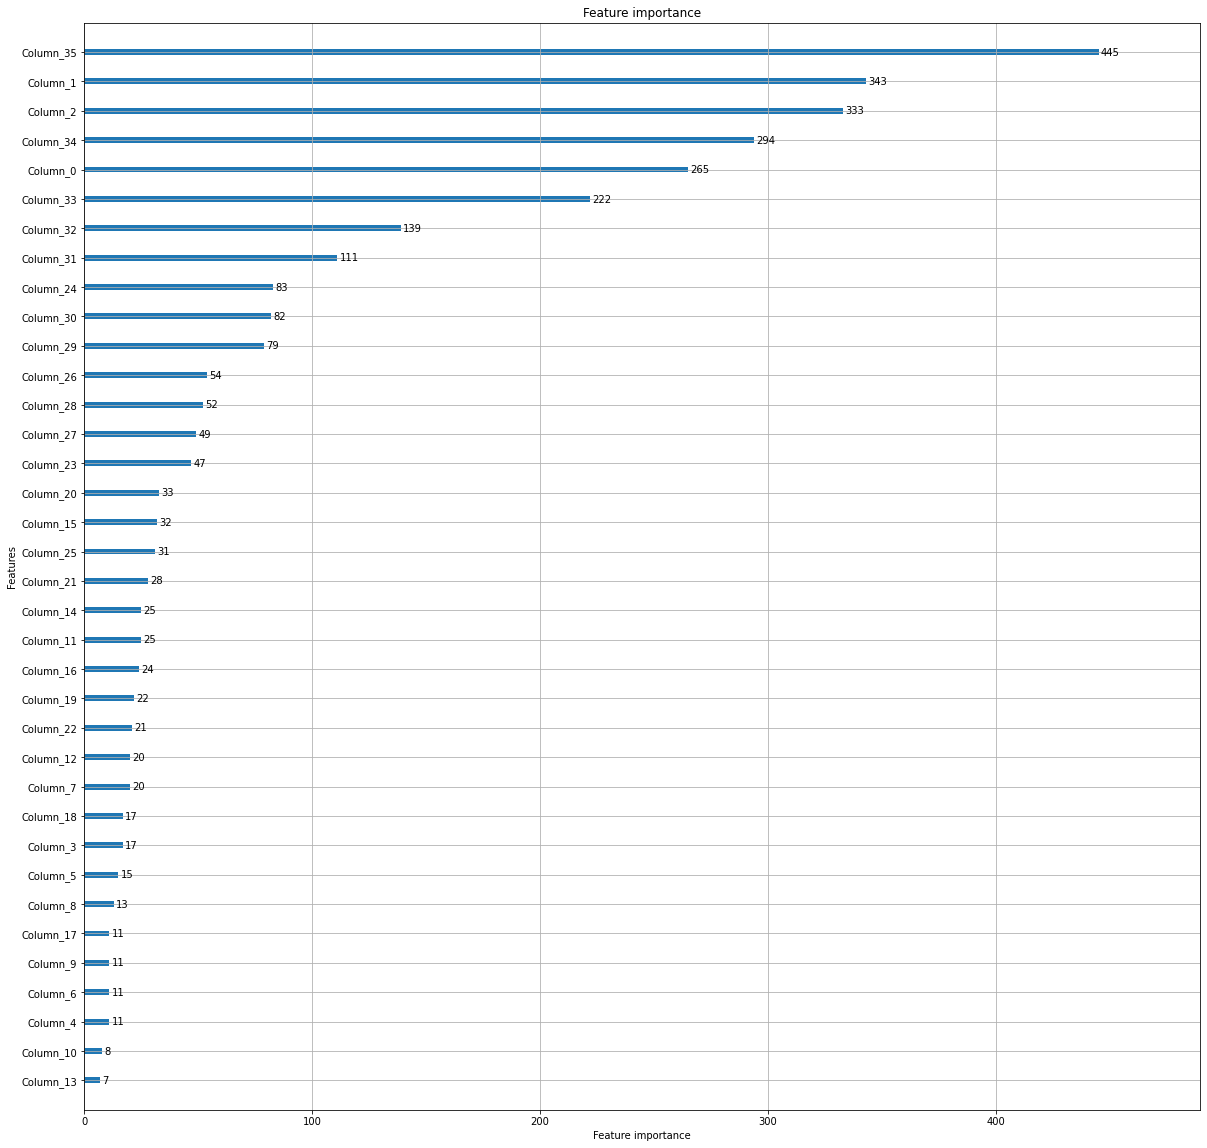

In [84]:
fig, ax = plt.subplots(figsize = (20, 20))
lgb.plot_importance(lgbmodel, ax = ax)

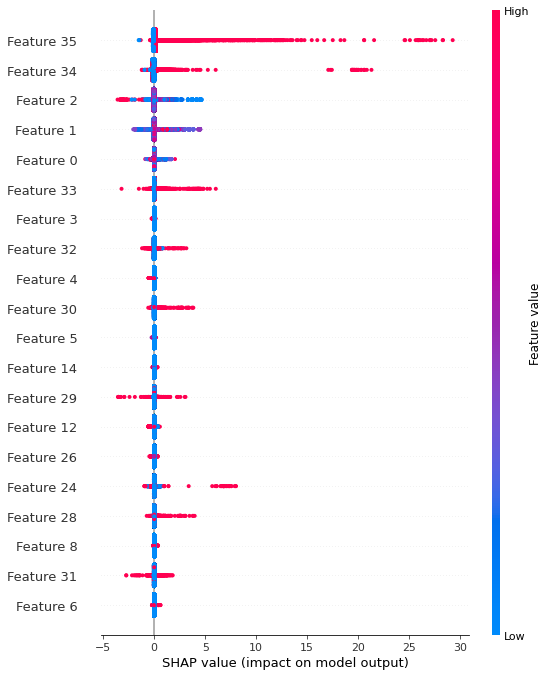

In [85]:
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

**Model 3: Linear Regression Models**



In [86]:
from sklearn.linear_model import LinearRegression

lrmodel = LinearRegression()
lrmodel.fit(X_train, y_train)

preds = lrmodel.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

0.7530990320942532


In [87]:
print('model intercept :', lrmodel.intercept_)
print('model coefficients : ', lrmodel.coef_)

model intercept : [-0.00724359]
model coefficients :  [[-7.70244438e-04  1.88239169e-06  6.85022203e-04 -1.79918951e-03
  -2.60815425e-03 -3.00223695e-03 -6.12851339e-03 -1.10869024e-04
   1.76250580e-02  9.62901484e-03 -3.70646407e-03 -1.28707132e-02
   9.61685533e-03  1.97711710e-03 -8.64579917e-03 -3.19148065e-03
   4.77175325e-03 -1.98289853e-03  1.48101806e-02  8.02915194e-04
   1.31192641e-02  2.82339544e-02  9.99493537e-03  7.07463076e-03
   2.60382596e-02  2.41280544e-02 -3.09260057e-02  2.69990393e-02
   4.94387360e-02  1.72488633e-02  3.52713590e-02  3.33814264e-02
   2.89136586e-02  6.83748386e-02  1.69429192e-01  2.88873210e-01]]


In [88]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

preds = ridge.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

0.7530991014740535


In [89]:
print('model intercept :', ridge.intercept_)
print('model coefficients : ', ridge.coef_)

model intercept : [-0.00724356]
model coefficients :  [[-7.70244705e-04  1.88238942e-06  6.85022958e-04 -1.79920315e-03
  -2.60815157e-03 -3.00225258e-03 -6.12852106e-03 -1.10842011e-04
   1.76250398e-02  9.62904096e-03 -3.70644785e-03 -1.28706777e-02
   9.61684982e-03  1.97713149e-03 -8.64579975e-03 -3.19146900e-03
   4.77173438e-03 -1.98285305e-03  1.48101440e-02  8.02987745e-04
   1.31192776e-02  2.82339006e-02  9.99497958e-03  7.07469064e-03
   2.60382708e-02  2.41280297e-02 -3.09258789e-02  2.69990250e-02
   4.94386128e-02  1.72489782e-02  3.52713709e-02  3.33815501e-02
   2.89139594e-02  6.83748454e-02  1.69428844e-01  2.88872362e-01]]


**Model 4: Ensemble Model**

In [90]:
from sklearn.ensemble import VotingRegressor

estimators = [('xgb', xgb.XGBRegressor()), ('lgb', lgb.LGBMRegressor())]

sr = VotingRegressor(estimators = estimators)
sr.fit(X_train, y_train)

preds = sr.predict(X_valid)
RMSE = np.sqrt(mean_squared_error(preds,y_valid))

print(RMSE)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.6103978046813519


**Model 5: Neural Network**

In [91]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model = keras.Sequential([
    layers.Dense(units=4, activation='relu', input_shape=[36]),
    layers.BatchNormalization(),
    layers.Dense(units=3, activation='relu'),
    layers.BatchNormalization(),
    # the linear output layer 
    layers.Dense(units=1),
])


model.compile(
    optimizer="adam",
    loss=rmse,
    metrics = [RootMeanSquaredError()]
)


model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=20,
)

Epoch 1/20
1307/1307 [==============================] - 8s 3ms/step - loss: 0.7390 - root_mean_squared_error: 0.9105 - val_loss: 1.2436 - val_root_mean_squared_error: 1.9743
Epoch 2/20
1307/1307 [==============================] - 3s 2ms/step - loss: 0.6743 - root_mean_squared_error: 0.8364 - val_loss: 0.7576 - val_root_mean_squared_error: 0.8959
Epoch 3/20
1307/1307 [==============================] - 3s 2ms/step - loss: 0.6639 - root_mean_squared_error: 0.8163 - val_loss: 4.3935 - val_root_mean_squared_error: 4.4004
Epoch 4/20
1307/1307 [==============================] - 3s 2ms/step - loss: 0.6625 - root_mean_squared_error: 0.8067 - val_loss: 1.8493 - val_root_mean_squared_error: 1.8634
Epoch 5/20
1307/1307 [==============================] - 3s 2ms/step - loss: 0.6630 - root_mean_squared_error: 0.7982 - val_loss: 0.8795 - val_root_mean_squared_error: 0.9521
Epoch 6/20
1307/1307 [==============================] - 3s 2ms/step - loss: 0.6601 - root_mean_squared_error: 0.7923 - val_loss: 1

In [92]:
'''explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(df_train.iloc[:,  (df_train.columns != 33)].values)'''

'explainer = shap.TreeExplainer(xgbmodel)\nshap_values = explainer.shap_values(df_train.iloc[:,  (df_train.columns != 33)].values)'

In [93]:
'''shap.summary_plot(shap_values, df_train.iloc[:,  (df_train.columns != 33)].values)'''

'shap.summary_plot(shap_values, df_train.iloc[:,  (df_train.columns != 33)].values)'

# **Testing the model and submission**

In [94]:
test = test.merge(df_train, how="left", on=["shop_id", "item_id"]).fillna(0.0)
test.head()

,ID,shop_id,item_id,item_category_name,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
d = dict(zip(test.columns[4:],list(np.array(list(test.columns[4:])) - 1)))

test = test.rename(d, axis = 1)

In [96]:
#predictions = bst.predict(test.iloc[:, (test.columns != 'ID') & (test.columns != -1)].values)
predictions = lgbmodel.predict(test.iloc[:, (test.columns != 'ID') & (test.columns != -1)].values)

In [97]:
x,y = test.shape

In [98]:
predictions = list(map(lambda x: min(20, max(x,0)), list(predictions)))
submission = pd.DataFrame({'ID': test.ID, 'item_cnt_month': predictions})
submission.to_csv('submission.csv', index=False)

Overall, after submitting to the competition, we observe that lgbmodel model gives us the best score on the test data
It is followed by Voting Regressor model and XGBoost

Link to the datasets:

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data